In [ ]:
# Import the relevant packages, define the device
!pip install -qU openimages torch_snippets urllib3
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 6.7 MB/s eta 0:00:00


In [ ]:
import json
import random
import pandas as pd
from tqdm import tqdm


# Loop through the content of the JSON file and fetch the information of the first 100,000 images
with open('open_images_train_captions.jsonl', 'r') as json_file:
 json_list = json_file.read().split('\n')
np.random.shuffle(json_list)
data = []
N = 100000
for ix, json_str in Tqdm(enumerate(json_list), N):
  if ix == N: 
    break
  try:
    result = json.loads(json_str)
    x = pd.DataFrame.from_dict(result, orient='index').T 
    data.append(x)
  except: 
    pass

result

100%|██████████| 100000/100000 [01:09<00:00, 1449.22it/s]


{'dataset_id': 'open_images',
 'image_id': '08278fb265463385',
 'annotator_id': 103,
 'caption': 'This is the picture of a place where we have a sunset and also we can see some trees and plants.'}

In [ ]:
# Split the dataframe (data) into training and validation datasets
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05]) 
data.to_csv('data.csv', index=False)

In [ ]:
# Download the images corresponding to the image IDs fetched from the JSON file:
from openimages.download import _download_images_by_id 
!mkdir -p train-images val-images
subset_imageIds = data[data['train']].image_id.tolist() 
_download_images_by_id(subset_imageIds, 'train', \
'./train-images/')
subset_imageIds = data[~data['train']].image_id.tolist() 
_download_images_by_id(subset_imageIds, 'train', \
'./val-images/')

100%|██████████| 4956/4956 [01:56<00:00, 42.37it/s]


In [ ]:
# A vocabulary object is something that can map every word in all the captions to a unique integer and vice versa
from torchtext.legacy.data import Field
from pycocotools.coco import COCO 
from collections import defaultdict
 
captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
all_captions = data[data['train']]['caption'].tolist() 
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist] 
captions.build_vocab(all_tokens)

In [ ]:
# Captions vocabulary components
class Vocab: 
  pass

vocab = Vocab() 
captions.vocab.itos.insert(0, '<pad>') 
vocab.itos = captions.vocab.itos
vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0
for s,i in captions.vocab.stoi.items():
  vocab.stoi[s] = i+1

In [ ]:
# Dataset class
from torchvision import transforms 

class CaptioningData(Dataset):
  def __init__(self, root, df, vocab): 
    self.df = df.reset_index(drop=True) 
    self.root = root
    self.vocab = vocab
    self.transform = transforms.Compose([ 
        transforms.Resize(224), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )


    # Returns one data pair (image and caption)
  def __getitem__(self, index):
    """Returns one data pair (image and caption)."""
    row = self.df.iloc[index].squeeze()
    id = row.image_id
    image_path = f'{self.root}/{id}.jpg'
    image = Image.open(os.path.join(image_path)).convert('RGB')
    caption = row.caption
    tokens = str(caption).lower().split()
    target = []
    target.append(vocab.stoi['<start>']) 
    target.extend([vocab.stoi[token] for token in tokens]) 
    target.append(vocab.stoi['<end>'])
    target = torch.Tensor(target).long()
    return image, target, caption

  def choose(self):
    return self[np.random.randint(len(self))]

  def __len__(self):
    return len(self.df)

  # Creates batch of captions and padds captions to be equal length
  def collate_fn(self, data):
    data.sort(key=lambda x: len(x[1]), reverse=True) 
    images, targets, captions = zip(*data)
    images = torch.stack([self.transform(image) for image in images], 0) 
    lengths = [len(tar) for tar in targets]
    _targets = torch.zeros(len(captions), max(lengths)).long()
    for i, tar in enumerate(targets): 
      end = lengths[i]
      _targets[i, :end] = tar[:end]
    return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)
      

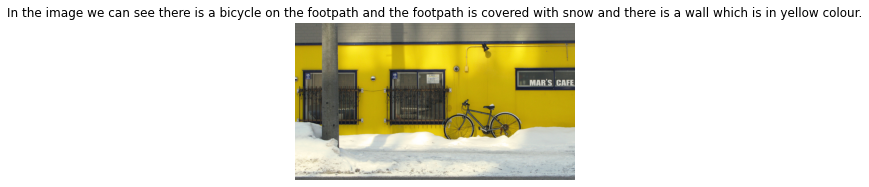

tensor[32] i64 x∈[2, 833] μ=111.812 σ=225.712

In [ ]:
#Define the training and validation dataset and data loaders
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)
image, target, caption = trn_ds.choose() 
# Show sample image and caption
show(image, title=caption, sz=5)
print(target)


In [ ]:
# Create the dataloaders for the datasets
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn) 
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)

# A sample batch
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

══════════════════════════════════════════════════════════════════

IMAGES:
Tensor  Shape: torch.Size([32, 3, 224, 224])    Min: -2.118     Max: 2.640      Mean: -0.063    dtype: 
torch.float32 @ cpu

══════════════════════════════════════════════════════════════════

TARGETS:
Tensor  Shape: torch.Size([32, 124])    Min: 0.000      Max: 7535.000   Mean: 50.495    dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

LENGTHS:
Tensor  Shape: torch.Size([32]) Min: 13.000     Max: 124.000    Mean: 41.281    dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence 
from torchvision import models

# The network class - EncoderCNN
class EncoderCNN(nn.Module):
      
  # Load the pretrained ResNet-152 and replace top fc layer
  def __init__(self, embed_size):
    """Load the pretrained ResNet-152 and replace top fc layer."""
    super(EncoderCNN, self).__init__()
    resnet = models.resnet152(pretrained=True)
    # delete the last fc layer.
    modules = list(resnet.children())[:-1]

    # Connect it to a linear layer
    self.resnet = nn.Sequential(*modules) 
    self.linear = nn.Linear(resnet.fc.in_features, \
    embed_size)
    # Pass it through batch normalization 
    self.bn = nn.BatchNorm1d(embed_size, \
    momentum=0.01)

  # Extract feature vectors from input images
  def forward(self, images):
    """Extract feature vectors from input images.""" 
    with torch.no_grad():
      features = self.resnet(images)
    features = features.reshape(features.size(0), -1) 
    features = self.bn(self.linear(features))
    return features

# Creating encoder instance
encoder = EncoderCNN(256).to(device)
!pip install torch_summary
from torchsummary import summary 
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5        

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-7              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-8              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-9              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-10             [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-11             [-1, 512, 28, 28]         280,064
|    └─Sequential: 2-7                   [-1, 1024, 14, 14]        --
|    |    └─Bottleneck: 3-12             [-1, 1024, 14, 14]        1,512,448
|    |    └─Bottleneck: 3-13             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-14             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-15             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-16             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-17             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-18             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-19             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-20             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-21             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-22             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-23             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-24             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-25             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-26             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-27             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-28             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-29             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-30             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-31             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-32             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-33             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-34             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-35             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-36             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-37             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-38             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-39             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-40             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-41             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-42             [-1, 1

In [ ]:
# Define the decoder architecture – DecoderRNN
class DecoderRNN(nn.Module):

  # Set the hyper-parameters and build the layers
  def __init__(self, embed_size, hidden_size, vocab_size, \
    num_layers, max_seq_length=80):
    """Set the hyper-parameters and build the layers.""" 
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size) 
    self.lstm = nn.LSTM(embed_size, hidden_size, \
    num_layers, batch_first=True) 
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

  # Decode image feature vectors and generates captions
  def forward(self, features, captions, lengths): 
    """Decode image feature vectors and generates captions."""
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), \
    embeddings), 1)
    packed = pack_padded_sequence(embeddings, \
    lengths.cpu(), batch_first=True) 
    outputs, _ = self.lstm(packed)
    outputs = self.linear(outputs[0]) 
    return outputs

  #Generate captions for given image features using greedy search
  def predict(self, features, states=None): 
    """Generate captions for given image features using greedy search.""" 
    sampled_ids = []
    inputs = features.unsqueeze(1)
    for i in range(self.max_seq_length):
      hiddens, states = self.lstm(inputs, states) 
      # hiddens: (batch_size, 1, hidden_size) 
      outputs = self.linear(hiddens.squeeze(1)) 
      # outputs: (batch_size, vocab_size)
      _, predicted = outputs.max(1)
      # predicted: (batch_size) 
      sampled_ids.append(predicted) 
      inputs = self.embed(predicted)
      # inputs: (batch_size, embed_size) 
      inputs = inputs.unsqueeze(1)
      # inputs: (batch_size, 1, embed_size)

    sampled_ids = torch.stack(sampled_ids, 1)
    # sampled_ids: (batch_size, max_seq_length)
    
    # convert predicted tokens to strings 
    sentences = []
    for sampled_id in sampled_ids:
      sampled_id = sampled_id.cpu().numpy() 
      sampled_caption = []
      for word_id in sampled_id:
        word = vocab.itos[word_id] 
        sampled_caption.append(word) 
        if word == '<end>':
          break
      sentence = ' '.join(sampled_caption) 
      sentences.append(sentence)
    return sentences

In [ ]:
# Trains on a single batch of data
def train_batch(data, encoder, decoder, optimizer, criterion): 
  encoder.train()
  decoder.train()
  images, captions, lengths = data
  images = images.to(device)
  captions = captions.to(device)
  targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0] 
  features = encoder(images)
  outputs = decoder(features, captions, lengths) 
  loss = criterion(outputs, targets) 
  decoder.zero_grad()
  encoder.zero_grad()
  loss.backward() 
  optimizer.step() 
  return loss

# Validate on a batch of data
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
  encoder.eval()
  decoder.eval()
  images, captions, lengths = data
  images = images.to(device)
  captions = captions.to(device)
  targets = pack_padded_sequence(captions, lengths.cpu(), \
  batch_first=True)[0] 
  features = encoder(images)
  outputs = decoder(features, captions, lengths) 
  loss = criterion(outputs, targets)
  return loss

# Define encoder, decoder, loss function, and optimizer
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device) 
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3) 
n_epochs = 10
log = Report(n_epochs)

In [ ]:
# Train the model over increasing epochs
for epoch in range(n_epochs):
  if epoch == 5: 
    optimizer = torch.optim.AdamW(params, lr=1e-4)
  N = len(trn_dl)
  for i, data in enumerate(trn_dl):
    trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
    pos = epoch + (1+i)/N
    log.record(pos=pos, trn_loss=trn_loss, end='\r')
  N = len(val_dl)
  for i, data in enumerate(val_dl):
    val_loss = validate_batch(data, encoder, decoder, criterion)
    pos = epoch + (1+i)/N
    log.record(pos=pos, val_loss=val_loss, end='\r') 
  log.report_avgs(epoch+1)
log.plot_epochs(log=True)

EPOCH: 0.055  trn_loss: 2.856  (3945.46s - 719633.07s remaining)

In [ ]:
# Train the model over increasing epochs
def load_image(image_path, transform=None):
  image = Image.open(image_path).convert('RGB') 
  image = image.resize([224, 224], Image.LANCZOS) 
  if transform is not None:
    tfm_image = transform(image)[None] 
  return image, tfm_image

def load_image_and_predict(image_path): 
  transform = transforms.Compose([
      transforms.ToTensor(), 
      transforms.Normalize(
          (0.485, 0.456, 0.406), 
          (0.229, 0.224, 0.225)
          )
  ])
  org_image, tfm_image = load_image(image_path, transform) 
  image_tensor = tfm_image.to(device)
  encoder.eval()
  decoder.eval()
  feature = encoder(image_tensor) 
  sentence = decoder.predict(feature)[0] 
  show(org_image, title=sentence) 
  return sentence

# Predict an image
files = Glob('val-images') 
load_image_and_predict(choose(files))